# TensorFlow Speech Recognition Challenge

### Can you build an algorithm that understands simple speech commands?

From here : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

- Signal pre-processing
- Deep CNN for classification

In [1]:
# Imports

import os
import re
from glob import glob
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

from __future__ import division
%matplotlib inline

# Signal Processing
from scipy.io import wavfile
from scipy.signal import stft

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from os.path import isdir, join
from pathlib import Path

# Math
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

# Principal components analysis
from sklearn.decomposition import PCA

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

print('Number of classes : {}'.format(len(id2name)))

Number of classes : 12


### Read data

In [3]:
def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label, label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    
    columns_list = ['label', 'label_id', 'user_id', 'wav_file']
    
    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    
    return train_df, valid_df

Combien d'exemples de test ?

In [4]:
train_df, valid_df = load_data('./data/')

There are 57929 train and 6798 val samples


In [5]:
train_df.head()

,label,label_id,user_id,wav_file
0,yes,0,708b8d51,./data/train/audio/yes/708b8d51_nohash_0.wav
1,yes,0,db79a764,./data/train/audio/yes/db79a764_nohash_0.wav
2,yes,0,c6a23ff5,./data/train/audio/yes/c6a23ff5_nohash_0.wav
3,yes,0,c93d5e22,./data/train/audio/yes/c93d5e22_nohash_2.wav
4,yes,0,b575b5fb,./data/train/audio/yes/b575b5fb_nohash_0.wav


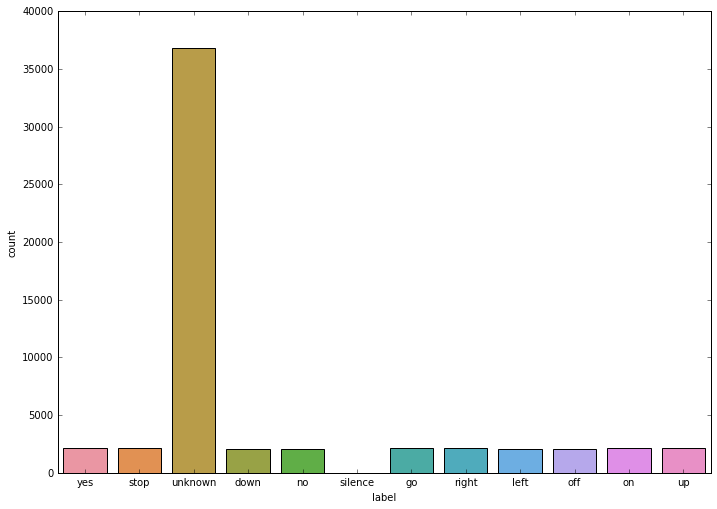

In [15]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.countplot(x="label", data=train_df)

In [7]:
silence_files = train_df[train_df.label == 'silence']
train_df      = train_df[train_df.label != 'silence']

In [8]:
def read_wav_file(fname):
    _, wav = wavfile.read(fname)
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
    return wav

In [9]:
silence_data = np.concatenate([read_wav_file(x) for x in silence_files.wav_file.values])

/usr/local/lib/python2.7/dist-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



### Process audio files

In [10]:
def process_wav_file(fname):
    wav = read_wav_file(fname)
    
    L = 16000  # 1 sec
    
    if len(wav) > L:
        i = np.random.randint(0, len(wav) - L)
        wav = wav[i:(i+L)]
    elif len(wav) < L:
        rem_len = L - len(wav)
        i = np.random.randint(0, len(silence_data) - rem_len)
        silence_part = silence_data[i:(i+L)]
        j = np.random.randint(0, rem_len)
        silence_part_left  = silence_part[0:j]
        silence_part_right = silence_part[j:rem_len]
        wav = np.concatenate([silence_part_left, wav, silence_part_right])
    
    specgram = stft(wav, 16000, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
    phase = np.angle(specgram[2]) / np.pi
    amp = np.log1p(np.abs(specgram[2]))
    
    return np.stack([phase, amp], axis = 2)

In [11]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)



### Audio visualizations

In [12]:
def plot_audio_file(filename, train_audio_path='data/train/audio/'):

    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

    freqs, times, spectrogram = log_specgram(samples, sample_rate)

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + filename)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + filename)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')
    
    plt.show()


def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

def plot_fft(filename, train_audio_path='data/train/audio/'):
    
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

'Yes' example :


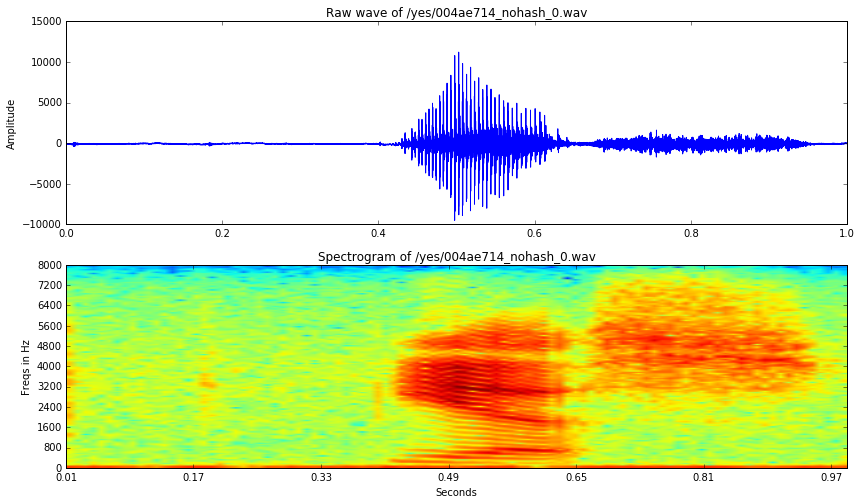

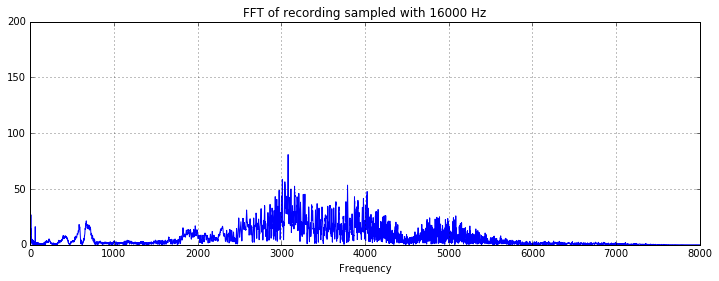

'Happy' example :


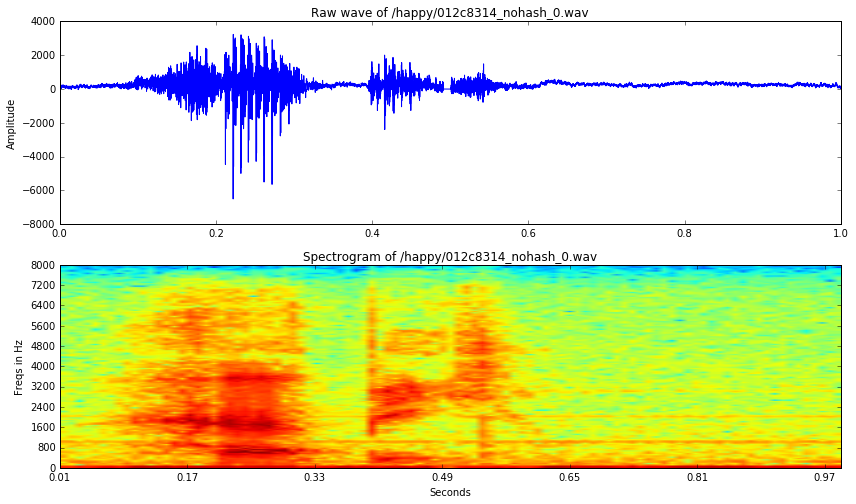

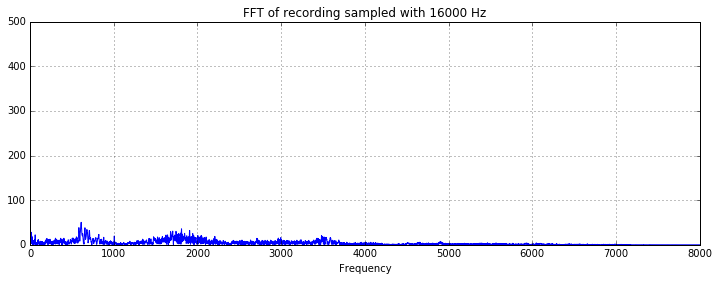

'Zero' example :


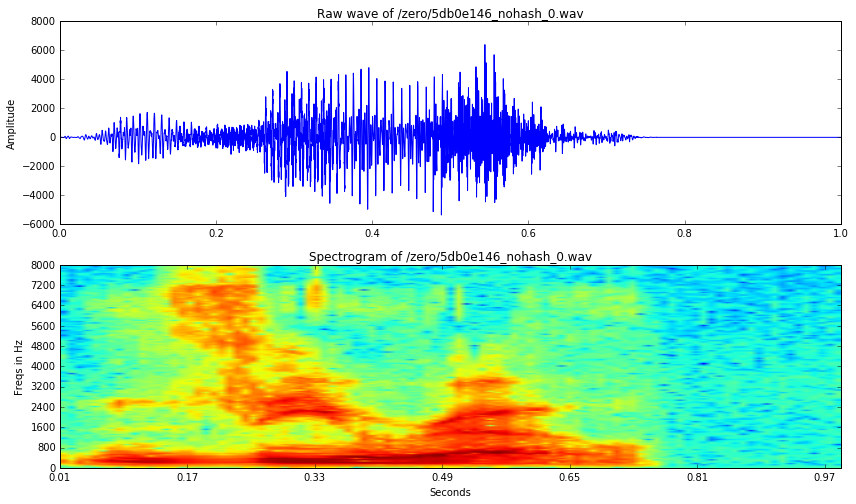

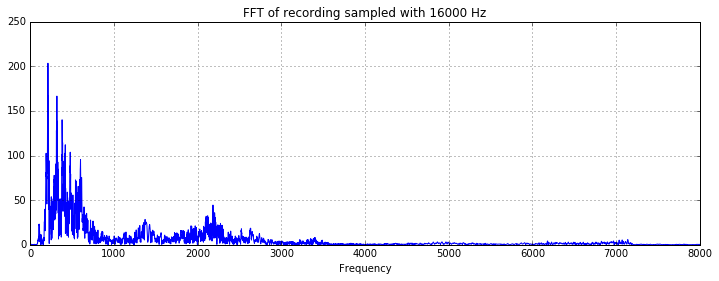

In [13]:
print("'Yes' example :")
yes_file = '/yes/004ae714_nohash_0.wav'
plot_audio_file(yes_file)
plot_fft(yes_file)

print("'Happy' example :")
happy_file = '/happy/012c8314_nohash_0.wav'
plot_audio_file(happy_file)
plot_fft(happy_file)

print("'Zero' example :")
zero_file = '/zero/5db0e146_nohash_0.wav'
plot_audio_file(zero_file)
plot_fft(zero_file)

### Build keras model

In [13]:
# Weights file
model_file = './weights/model.hdf5'

In [14]:
import random
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.utils import to_categorical

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
def train_generator(train_batch_size):
    while True:
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(process_wav_file(this_train.wav_file.values[i]))
                y_batch.append(this_train.label_id.values[i])
            x_batch = np.array(x_batch)
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch


In [16]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(process_wav_file(valid_df.wav_file.values[i]))
                y_batch.append(valid_df.label_id.values[i])
            x_batch = np.array(x_batch)
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [17]:
def build_model():
    """ return keras model """
    x_in = Input(shape = (257,98,2))
    x = BatchNormalization()(x_in)
    for i in range(4):
        x = Conv2D(16*(2 ** i), (3,3))(x)
        x = Activation('elu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (1,1))(x)
    x_branch_1 = GlobalAveragePooling2D()(x)
    x_branch_2 = GlobalMaxPool2D()(x)
    x = concatenate([x_branch_1, x_branch_2])
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(len(POSSIBLE_LABELS), activation = 'softmax')(x)
    model = Model(inputs = x_in, outputs = x)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [19]:
model = build_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 257, 98, 2)    0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 257, 98, 2)    8           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 255, 96, 16)   304         batch_normalization_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 255, 96, 16)   0           conv2d_1[0][0]                   
___________________________________________________________________________________________

### Load model weights

In [20]:
print('Loading model from {}'.format(model_file))
model.load_weights(model_file)

Loading model from ./weights/model.hdf5


### Train the model

In [21]:
callbacks = [ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                               mode='min'),
             ModelCheckpoint(monitor='val_loss',
                             filepath=model_file,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')]

# EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.01, mode='min')

In [22]:
# 40 epochs ont ete faite sur model.hdf5

model.fit_generator(generator=train_generator(64),
                              steps_per_epoch=344,
                              epochs=10,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=valid_generator(64),
                              validation_steps=int(np.ceil(valid_df.shape[0]/64)))

Epoch 1/10
344/344 [==============================] - 1437s - loss: 0.2355 - acc: 0.9353 - val_loss: 0.4210 - val_acc: 0.9081
Epoch 2/10
344/344 [==============================] - 1428s - loss: 0.2310 - acc: 0.9365 - val_loss: 0.7851 - val_acc: 0.8185
Epoch 3/10
344/344 [==============================] - 1432s - loss: 0.2231 - acc: 0.9361 - val_loss: 0.5859 - val_acc: 0.8572
Epoch 4/10
344/344 [==============================] - 1446s - loss: 0.2222 - acc: 0.9391 - val_loss: 0.5846 - val_acc: 0.8625
Epoch 5/10
343/344 [============================>.] - ETA: 3s - loss: 0.2239 - acc: 0.9388
Epoch 00004: reducing learning rate to 0.00010000000475.
344/344 [==============================] - 1433s - loss: 0.2240 - acc: 0.9388 - val_loss: 0.5846 - val_acc: 0.8489
Epoch 6/10
344/344 [==============================] - 1435s - loss: 0.1276 - acc: 0.9613 - val_loss: 0.4270 - val_acc: 0.9035
Epoch 7/10
344/344 [==============================] - 1435s - loss: 0.1048 - acc: 0.9683 - val_loss: 0.4160

### Test the model

6464/6464 [==============================] - 94s    

Report
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       261
          1       0.83      0.94      0.88       270
          2       0.00      0.00      0.00         0
          3       0.88      0.93      0.91       264
          4       0.79      0.94      0.86       247
          5       0.84      0.91      0.87       256
          6       0.85      0.91      0.88       257
          7       0.81      0.93      0.86       256
          8       0.85      0.90      0.88       246
          9       0.75      0.85      0.80       260
         11       0.98      0.91      0.95      4147

avg / total       0.93      0.91      0.92      6464


Confusion matrix


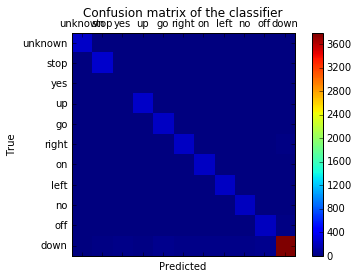

In [22]:
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import confusion_matrix, classification_report

def generator_to_subset(gen, size):
    """ Return a ndarray of size elements for generator gen (gen yields mini batches (X, y)) """
    X, Y = next(gen)
    for _ in range(size):
        x, y = next(gen)
        X = np.concatenate((X, x), axis=0)
        Y = np.concatenate((Y, y), axis=0)
    return X, Y

def plot_confusion_matrix(cm, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    
    # Force multi labels
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

test_set, test_labels = generator_to_subset(valid_generator(64), 100) # 6798 validation instances
test_labels = np.argmax(test_labels, axis=1)

# Predicting classes
y_pred = model.predict(test_set, batch_size=64, verbose=1)
target_names = ['unknown', 'stop', 'yes', 'up', 'go', 'right', 'on', 'left', 'no', 'off', 'down', 'silence']
predicted_classes = np.argmax(y_pred, axis=1)
   
print("\nReport")
print(classification_report(test_labels, predicted_classes)) #, target_names=target_names, digits = 3))
      
print("\nConfusion matrix")    
cm = confusion_matrix(test_labels, predicted_classes)
plot_confusion_matrix(cm, target_names)
print("\n\n")

### Prepare Kaggle submission

In [23]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [24]:
def test_generator(test_batch_size):
    while True:
        for start in range(0, len(test_paths), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(test_paths))
            this_paths = test_paths[start:end]
            for x in this_paths:
                x_batch.append(process_wav_file(x))
            x_batch = np.array(x_batch)
            yield x_batch

In [25]:
predictions = model.predict_generator(test_generator(64), steps=int(np.ceil(len(test_paths)/64)))

In [26]:
classes = np.argmax(predictions, axis=1)

In [27]:
# last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [28]:
#submission

In [29]:
with open('submission.csv', 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))